<a href="https://colab.research.google.com/github/Chichinora/Chichinora.github.io/blob/main/%E6%9C%80%E4%BD%B3faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#下載資料集
import gdown
import os
import shutil

#下載training_image.zip
gdown.download("https://drive.google.com/uc?export=download&id=1UZFnnQVTA9ORchEiltETcAhF_L1ZgjE5","/content/training_image.zip")
#下載training_label.zip
gdown.download("https://drive.google.com/uc?export=download&id=16QL2MhStoZfQ6mR79Du8staDfNHn-hMj","/content/training_label.zip")
#下載訓練aortic_valve_colab.yaml
gdown.download("https://drive.google.com/uc?export=download&id=1TcJtwhAvI00O68Y8WUhpVIk3-8gO0O-k","/content/aortic_valve_colab.yaml")
gdown.download("https://drive.google.com/uc?export=download&id=1u1arxQYSIzN6WNO-KvHDkBfx7MubtUgF","/content/42_testing_image.zip")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1UZFnnQVTA9ORchEiltETcAhF_L1ZgjE5
From (redirected): https://drive.google.com/uc?export=download&id=1UZFnnQVTA9ORchEiltETcAhF_L1ZgjE5&confirm=t&uuid=a5de4cd7-14ea-40d2-a980-a7569c81b639
To: /content/training_image.zip
100%|██████████| 1.83G/1.83G [00:25<00:00, 70.4MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=16QL2MhStoZfQ6mR79Du8staDfNHn-hMj
To: /content/training_label.zip
100%|██████████| 573k/573k [00:00<00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1TcJtwhAvI00O68Y8WUhpVIk3-8gO0O-k
To: /content/aortic_valve_colab.yaml
100%|██████████| 91.0/91.0 [00:00<00:00, 432kB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1u1arxQYSIzN6WNO-KvHDkBfx7MubtUgF
From (redirected): https://drive.google.com/uc?export=download&id=1u1arxQYSIzN6WNO-KvHDkBfx7MubtUgF&confirm=t&uuid=8db8cb1c-4ce3-4b8a-9ac6-4032a00165d1
To: /content

'/content/42_testing_image.zip'

In [2]:
import gdown
import os
import shutil
from sklearn.model_selection import KFold


# 移動檔案 (用戶提供的 code)
def find_patient_root(root):
    """往下找，直到找到含有 patientXXXX 的資料夾"""
    for dirpath, dirnames, filenames in os.walk(root):
        if any(d.startswith("patient") for d in dirnames):
            return dirpath
    return root  # fallback

# 清理並重新解壓縮到固定資料夾
if os.path.exists("./training_image"):
    shutil.rmtree("./training_image")
if os.path.exists("./training_label"):
    shutil.rmtree("./training_label")

os.makedirs("./training_image", exist_ok=True)
os.makedirs("./training_label", exist_ok=True)

if os.path.exists("training_image.zip"):
    !unzip -o -q training_image.zip -d ./training_image  # -o 強制覆蓋
if os.path.exists("training_label.zip"):
    !unzip -o -q training_label.zip -d ./training_label  # -o 強制覆蓋


IMG_ROOT = find_patient_root("./training_image")
LBL_ROOT = find_patient_root("./training_label")

print("IMG_ROOT =", IMG_ROOT)
print("LBL_ROOT =", LBL_ROOT)


base_dir = '/content/dataset'
os.makedirs(os.path.join(base_dir, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'labels/train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'labels/val'), exist_ok=True)



def move_patients(patients_list, split):
    """根據 patients_list 移動圖像和標註"""
    for patient_num in patients_list:
        patient = f"patient{patient_num:04d}"
        img_dir = os.path.join(IMG_ROOT, patient)
        lbl_dir = os.path.join(LBL_ROOT, patient)
        if not os.path.isdir(lbl_dir):
            print(f"警告: {patient} 無標註資料夾，跳過")
            continue

        for fname in os.listdir(lbl_dir):
            if not fname.endswith(".txt"):
                continue

            label_path = os.path.join(lbl_dir, fname)
            base, _ = os.path.splitext(fname)  # 取出檔名不含副檔名
            img_path = os.path.join(img_dir, base + ".png")
            if not os.path.exists(img_path):
                print(f"找不到對應圖片: {img_path}")
                continue

            shutil.move(img_path, os.path.join(base_dir, f'images/{split}', base + ".png"))
            shutil.move(label_path, os.path.join(base_dir, f'labels/{split}', base + ".txt"))


# 收集所有 patients
patients = sorted([p for p in os.listdir(IMG_ROOT) if p.startswith('patient')])
patient_nums = [int(p[7:]) for p in patients]  # 提取 patient 編號 (e.g., 1, 2, ..., 50)

# 為 5-fold CV 準備 (匹配論文)，loop over folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(patient_nums)):
    print(f'Fold {fold+1}')
    # 清空資料夾
    for d in ['images/train', 'images/val', 'labels/train', 'labels/val']:
        shutil.rmtree(os.path.join(base_dir, d), ignore_errors=True)
        os.makedirs(os.path.join(base_dir, d))

    # 移動 train patients
    train_patients = [patient_nums[i] for i in train_idx]
    move_patients(train_patients, "train")

    # 移動 val patients
    val_patients = [patient_nums[i] for i in val_idx]
    move_patients(val_patients, "val")

    # 檢查移動後的檔案數量
    print("The number of Train images:", len(os.listdir(os.path.join(base_dir, 'images/train'))))
    print("The number of Val images:", len(os.listdir(os.path.join(base_dir, 'images/val'))))
    print("The number of Train labels:", len(os.listdir(os.path.join(base_dir, 'labels/train'))))
    print("The number of Val labels:", len(os.listdir(os.path.join(base_dir, 'labels/val'))))

    # 只跑一 fold 來 demo，comment out to run all folds and average
    break

print("完成移動！")

IMG_ROOT = ./training_image
LBL_ROOT = ./training_label
Fold 1
The number of Train images: 2251
The number of Val images: 536
The number of Train labels: 2251
The number of Val labels: 536
完成移動！


In [3]:
!pip install -q torch torchvision opencv-python tqdm
# 安裝必要套件
!pip install -q torch torchvision opencv-python tqdm gdown

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from tqdm import tqdm


In [4]:
import gdown, shutil
from sklearn.model_selection import KFold

# === 下載資料 ===
gdown.download("https://drive.google.com/uc?export=download&id=1UZFnnQVTA9ORchEiltETcAhF_L1ZgjE5","/content/training_image.zip")
gdown.download("https://drive.google.com/uc?export=download&id=16QL2MhStoZfQ6mR79Du8staDfNHn-hMj","/content/training_label.zip")

# === 解壓縮 ===
!unzip -o -q training_image.zip -d ./training_image
!unzip -o -q training_label.zip -d ./training_label

# 找出根目錄
def find_patient_root(root):
    for dirpath, dirnames, _ in os.walk(root):
        if any(d.startswith("patient") for d in dirnames):
            return dirpath
    return root

IMG_ROOT = find_patient_root("./training_image")
LBL_ROOT = find_patient_root("./training_label")

print("IMG_ROOT =", IMG_ROOT)
print("LBL_ROOT =", LBL_ROOT)

# 建立新的資料夾結構
base_dir = '/content/dataset'
os.makedirs(os.path.join(base_dir, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'labels/train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'labels/val'), exist_ok=True)

# 定義搬移函式
def move_patients(patients_list, split):
    for patient_num in patients_list:
        patient = f"patient{patient_num:04d}"
        img_dir = os.path.join(IMG_ROOT, patient)
        lbl_dir = os.path.join(LBL_ROOT, patient)
        if not os.path.isdir(lbl_dir):
            continue
        for fname in os.listdir(lbl_dir):
            if not fname.endswith(".txt"):
                continue
            label_path = os.path.join(lbl_dir, fname)
            base, _ = os.path.splitext(fname)
            img_path = os.path.join(img_dir, base + ".png")
            if not os.path.exists(img_path):
                continue
            shutil.move(img_path, os.path.join(base_dir, f'images/{split}', base + ".png"))
            shutil.move(label_path, os.path.join(base_dir, f'labels/{split}', base + ".txt"))

# 拆分資料 (5-Fold CV，這裡只取第1 Fold)
patients = sorted([p for p in os.listdir(IMG_ROOT) if p.startswith('patient')])
patient_nums = [int(p[7:]) for p in patients]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(patient_nums)):
    print(f'Fold {fold+1}')
    for d in ['images/train', 'images/val', 'labels/train', 'labels/val']:
        shutil.rmtree(os.path.join(base_dir, d), ignore_errors=True)
        os.makedirs(os.path.join(base_dir, d))
    move_patients([patient_nums[i] for i in train_idx], "train")
    move_patients([patient_nums[i] for i in val_idx], "val")
    print("Train:", len(os.listdir(os.path.join(base_dir, 'images/train'))))
    print("Val:", len(os.listdir(os.path.join(base_dir, 'images/val'))))
    break  # 只做第1 fold
print("✅ 資料整理完成！")


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1UZFnnQVTA9ORchEiltETcAhF_L1ZgjE5
From (redirected): https://drive.google.com/uc?export=download&id=1UZFnnQVTA9ORchEiltETcAhF_L1ZgjE5&confirm=t&uuid=4821ea32-c979-4560-8e2c-6ba829026651
To: /content/training_image.zip
100%|██████████| 1.83G/1.83G [00:22<00:00, 81.7MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=16QL2MhStoZfQ6mR79Du8staDfNHn-hMj
To: /content/training_label.zip
100%|██████████| 573k/573k [00:00<00:00, 69.2MB/s]


IMG_ROOT = ./training_image
LBL_ROOT = ./training_label
Fold 1
Train: 2251
Val: 536
✅ 資料整理完成！


In [5]:
class AorticValveDataset(Dataset):
    def __init__(self, img_dir, label_dir, transforms=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.imgs = [f for f in os.listdir(img_dir) if f.endswith(".png")]
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        label_path = os.path.join(self.label_dir, self.imgs[idx].replace(".png", ".txt"))
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        boxes, labels = [], []
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls, x, y, bw, bh = map(float, line.strip().split())
                x1 = (x - bw / 2) * w
                y1 = (y - bh / 2) * h
                x2 = (x + bw / 2) * w
                y2 = (y + bh / 2) * h
                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls) + 1)  # 類別從1開始

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        img = F.to_tensor(img)
        return img, target

    def __len__(self):
        return len(self.imgs)


In [6]:
train_dataset = AorticValveDataset(
    img_dir=f"{base_dir}/images/train",
    label_dir=f"{base_dir}/labels/train"
)
val_dataset = AorticValveDataset(
    img_dir=f"{base_dir}/images/val",
    label_dir=f"{base_dir}/labels/val"
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"✅ Train batch: {len(train_loader)}, Val batch: {len(val_loader)}")


✅ Train batch: 563, Val batch: 134


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2  # 1 類別 (aortic valve) + 背景

model = fasterrcnn_resnet50_fpn_v2(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:02<00:00, 72.6MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [8]:
import torch
import torch.optim as optim
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.ops import box_iou # 確保 box_iou 有被 import

# =======================
# 1️. 設定裝置與模型
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2 # 1 類別 (aortic valve) + 背景

model = fasterrcnn_resnet50_fpn_v2(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# =======================
# 2️. 訓練參數
# =======================
#  調整：學習率從 1e-4 提高到 3e-4
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
#  調整：增加 Epoch 數到 30
num_epochs = 30


# 最佳權重追蹤變數
best_mAP = 0.0
best_epoch = 0
WEIGHTS_PATH = "fasterrcnn_aortic_valve.pth"

# =======================
# 3️. 評估函式
# =======================
def evaluate_model(model, data_loader, device, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    total_tp, total_fp, total_fn = 0, 0, 0
    total_precision, total_recall = [], []

    with torch.no_grad():
        for imgs, targets in tqdm(data_loader, desc="Evaluating"):
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(imgs)

            for output, target in zip(outputs, targets):
                gt_boxes = target["boxes"]
                pred_boxes = output["boxes"][output["scores"] > score_threshold]

                if len(pred_boxes) == 0:
                    total_fn += len(gt_boxes)
                    continue

                ious = box_iou(pred_boxes, gt_boxes) # [num_pred, num_gt]
                max_iou, indices = ious.max(dim=0) # 每個 gt 找最佳 pred
                tp = (max_iou >= iou_threshold).sum().item()
                fp = len(pred_boxes) - tp
                fn = len(gt_boxes) - tp

                total_tp += tp
                total_fp += fp
                total_fn += fn

    precision = total_tp / (total_tp + total_fp + 1e-8)
    recall = total_tp / (total_tp + total_fn + 1e-8)

    mAP50 = precision
    return mAP50, precision, recall

# =======================
# 4️. 訓練迴圈 + 評估 + 儲存最佳模型
# =======================
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()
    avg_loss = total_loss / len(train_loader)

    # =======================
    # Validation 評估
    # =======================
    mAP, precision, recall = evaluate_model(model, val_loader, device)

    #  檢查是否為最佳模型並儲存
    if mAP > best_mAP:
        best_mAP = mAP
        best_epoch = epoch + 1
        torch.save(model.state_dict(), WEIGHTS_PATH)
        print(f" 儲存新的最佳模型！mAP = {best_mAP:.4f} (來自 Epoch {best_epoch})")

    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f} | "
          f"mAP@0.5 = {mAP:.4f} | Precision = {precision:.4f} | Recall = {recall:.4f}")

# =======================
# 5️. 訓練完成總結
# =======================
print(f"✅ 訓練完成！最佳模型權重已儲存為 {WEIGHTS_PATH} (來自 Epoch {best_epoch})")

Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


⭐ 儲存新的最佳模型！mAP = 0.7732 (來自 Epoch 1)
Epoch 1: Train Loss = 0.1014 | mAP@0.5 = 0.7732 | Precision = 0.7732 | Recall = 0.9478


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]


⭐ 儲存新的最佳模型！mAP = 0.8148 (來自 Epoch 2)
Epoch 2: Train Loss = 0.0659 | mAP@0.5 = 0.8148 | Precision = 0.8148 | Recall = 0.9683


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


⭐ 儲存新的最佳模型！mAP = 0.8557 (來自 Epoch 3)
Epoch 3: Train Loss = 0.0587 | mAP@0.5 = 0.8557 | Precision = 0.8557 | Recall = 0.9291


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]


Epoch 4: Train Loss = 0.0580 | mAP@0.5 = 0.8325 | Precision = 0.8325 | Recall = 0.9739


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


Epoch 5: Train Loss = 0.0506 | mAP@0.5 = 0.8124 | Precision = 0.8124 | Recall = 0.9534


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]


⭐ 儲存新的最佳模型！mAP = 0.8581 (來自 Epoch 6)
Epoch 6: Train Loss = 0.0461 | mAP@0.5 = 0.8581 | Precision = 0.8581 | Recall = 0.9366


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


Epoch 7: Train Loss = 0.0385 | mAP@0.5 = 0.7795 | Precision = 0.7795 | Recall = 0.9366


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


⭐ 儲存新的最佳模型！mAP = 0.8905 (來自 Epoch 8)
Epoch 8: Train Loss = 0.0383 | mAP@0.5 = 0.8905 | Precision = 0.8905 | Recall = 0.9403


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


Epoch 9: Train Loss = 0.0411 | mAP@0.5 = 0.8538 | Precision = 0.8538 | Recall = 0.9478


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


Epoch 10: Train Loss = 0.0309 | mAP@0.5 = 0.8638 | Precision = 0.8638 | Recall = 0.9347


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


Epoch 11: Train Loss = 0.0310 | mAP@0.5 = 0.8247 | Precision = 0.8247 | Recall = 0.9478


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.94it/s]


Epoch 12: Train Loss = 0.0287 | mAP@0.5 = 0.8726 | Precision = 0.8726 | Recall = 0.9459


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


Epoch 13: Train Loss = 0.0289 | mAP@0.5 = 0.8699 | Precision = 0.8699 | Recall = 0.9478


Evaluating: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


Epoch 14: Train Loss = 0.0324 | mAP@0.5 = 0.8353 | Precision = 0.8353 | Recall = 0.9179


Epoch 15/30:  22%|██▏       | 126/563 [02:19<08:05,  1.11s/it]


KeyboardInterrupt: 

In [9]:
!apt-get install p7zip-full -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [12]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# =======================================================
# AorticValveInferenceDataset
# =======================================================
class AorticValveInferenceDataset(Dataset):
    def __init__(self, img_root, transforms=None):
        self.img_root = img_root

        self.img_paths = sorted(glob.glob(os.path.join(img_root, '**', '*.png'), recursive=True))
        self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]


        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        H, W, _ = image.shape
        img_name = os.path.splitext(os.path.basename(img_path))[0]

        # 使用 Albumentations 推論轉換
        if self.transforms:
            # Albumentations 對 NumPy array 進行操作
            augmented = self.transforms(image=image)
            image_tensor = augmented['image']
        else:
            # Fallback
            from torchvision.transforms import functional as F
            image_tensor = F.to_tensor(image)

        # 回傳 tensor, 檔名 (不含副檔名), H, W
        return image_tensor, img_name, H, W

# =======================================================
# 1. 設置路徑與解壓縮
# =======================================================
ZIP_PATH = '/content/42_testing_image.zip'
TEST_IMG_DIR_BASE = './test_images_folder_final'

# 找出根目錄的函式
def find_patient_root(root):
    for dirpath, dirnames, _ in os.walk(root):
        if any(d.startswith("patient") for d in dirnames):
            return dirpath
    return root

if os.path.exists(ZIP_PATH):
    print(f" 找到測試集壓縮檔: {ZIP_PATH}")
    os.makedirs(TEST_IMG_DIR_BASE, exist_ok=True)

    # *** 核心解壓縮：使用 7z ***
    print(f" 正在使用 7z 解壓縮到 {TEST_IMG_DIR_BASE}...")
    !7z x {ZIP_PATH} -o{TEST_IMG_DIR_BASE} -y
    # **************************

    # ⭐ 修正：使用 find_patient_root 找到實際的影像根目錄
    INFERENCE_ROOT = find_patient_root(TEST_IMG_DIR_BASE)

    print(f" 修正後的影像搜尋根目錄設定為: {INFERENCE_ROOT}")

    # =======================================================
    # 2. 定義推論 transforms (使用 Albumentations 配合訓練)
    # =======================================================
    # 必須包含訓練時的 Resize 和 Normalize
    inference_transforms = A.Compose([
        A.Resize(height=512, width=512),

        A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0),
        ToTensorV2()
    ])

    # 創建 Dataset
    inference_dataset = AorticValveInferenceDataset(INFERENCE_ROOT, transforms=inference_transforms)

    # 創建 DataLoader
    #  batch_size=1
    def inference_collate_fn(batch):
        # batch 格式：[(tensor, name, H, W)]
        img = batch[0][0].unsqueeze(0)  # 圖像 Tensor: [1, C, H, W]
        name = batch[0][1]              # 檔名
        H = batch[0][2]               # 原始高
        W = batch[0][3]               # 原始寬
        return img, name, H, W

    inference_loader = DataLoader(
        inference_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=inference_collate_fn
    )

    print(f" 推論 DataLoader 完成，共 {len(inference_dataset)} 張影像。")

else:
    INFERENCE_ROOT = None
    inference_loader = None
    print("未找到測試集壓縮檔，無法進行推論準備")

✅ 找到測試集壓縮檔: /content/42_testing_image.zip
📦 正在使用 7z 解壓縮到 ./test_images_folder_final...

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 1832057363 bytes (1748 MiB)

Extracting archive: /content/42_testing_image.zip
 24% 4096 Open              --
Path = /content/42_testing_image.zip
Type = zip
Physical Size = 1832057363

  0%      0% 67 - testing_image/patient0051/patient0051_0066.png                                                          0% 157 - testing_image/patient0051/patient0051_0156.png                              

In [16]:
# =======================
# 10. 推論與提交檔案生成
# =======================
import os
import torch
from tqdm import tqdm
import numpy as np

# 載入訓練好的模型權重
WEIGHTS_PATH = "fasterrcnn_aortic_valve.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if os.path.exists(WEIGHTS_PATH):
    try:

        model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))
        print(f" 成功載入模型權重: {WEIGHTS_PATH}")
    except NameError:
        print(f"模型 'model' 尚未定義")
        # 如果在 Notebook 環境下運行，使用 exit() 或 raise Exception
        raise Exception("模型 'model' 尚未定義")
else:
    print(f"找不到權重檔 '{WEIGHTS_PATH}'，無法進行推論")
    raise Exception("找不到模型權重檔案")

model.eval() # 設置為評估模式
all_results = []

COMPETITION_CLASS_ID = 0
CONFIDENCE_THRESHOLD = 0.5
TARGET_LABEL = 1 # 模型內部標籤 (背景為0，主動脈瓣為1)


if 'inference_loader' in locals() and inference_loader:
    with torch.no_grad():
        for images_tensor, img_ids, heights, widths in tqdm(inference_loader, desc="生成提交結果"):
            images_tensor = images_tensor.to(device)
            img_id = img_ids


            H, W = heights, widths


            if isinstance(img_id, (list, tuple)):
                img_id = img_id[0]

            outputs = model(images_tensor) # 模型推論

            boxes = outputs[0]['boxes'].cpu().numpy()
            scores = outputs[0]['scores'].cpu().numpy()
            labels = outputs[0]['labels'].cpu().numpy()

            # 獲取圖像尺寸變換後的比例 (為了將預測框從 512x512 映射回原始尺寸 WxH)
            RESIZE_SIZE = 512
            scale_x = W / RESIZE_SIZE
            scale_y = H / RESIZE_SIZE

            for box, score, label in zip(boxes, scores, labels):
                # 篩選目標類別 (1) 且信心分數高於門檻
                if label == TARGET_LABEL and score >= CONFIDENCE_THRESHOLD:

                    x_min_norm, y_min_norm, x_max_norm, y_max_norm = box

                    # 將預測框座標從 512x512 縮放回原始尺寸 HxW
                    x_min = int(x_min_norm * scale_x)
                    y_min = int(y_min_norm * scale_y)
                    x_max = int(x_max_norm * scale_x)
                    y_max = int(y_max_norm * scale_y)

                    # 限制在圖片範圍內
                    x_min = np.clip(x_min, 0, W)
                    y_min = np.clip(y_min, 0, H)
                    x_max = np.clip(x_max, x_min, W)
                    y_max = np.clip(y_max, y_min, H)

                    # 格式化信心分數
                    conf_str = f"{score:.4f}"


                    output_line = (
                        f"{img_id} {COMPETITION_CLASS_ID} {conf_str} "
                        f"{x_min} {y_min} {x_max} {y_max}"
                    )

                    all_results.append(output_line)
else:
    print(" inference_loader 未定義或為空")


# --- 寫入最終提交檔案 ---
SUBMISSION_FILE = 'submission.txt'

with open(SUBMISSION_FILE, 'w') as f:
    for line in all_results:
        f.write(line + '\n')

print(f"提交檔案 '{SUBMISSION_FILE}' 已成功生成，共包含 {len(all_results)} 條預測結果。")

✅ 成功載入模型權重: fasterrcnn_aortic_valve.pth


生成提交結果: 100%|██████████| 16620/16620 [35:13<00:00,  7.86it/s]

✅ 提交檔案 'submission.txt' 已成功生成，共包含 3190 條預測結果。


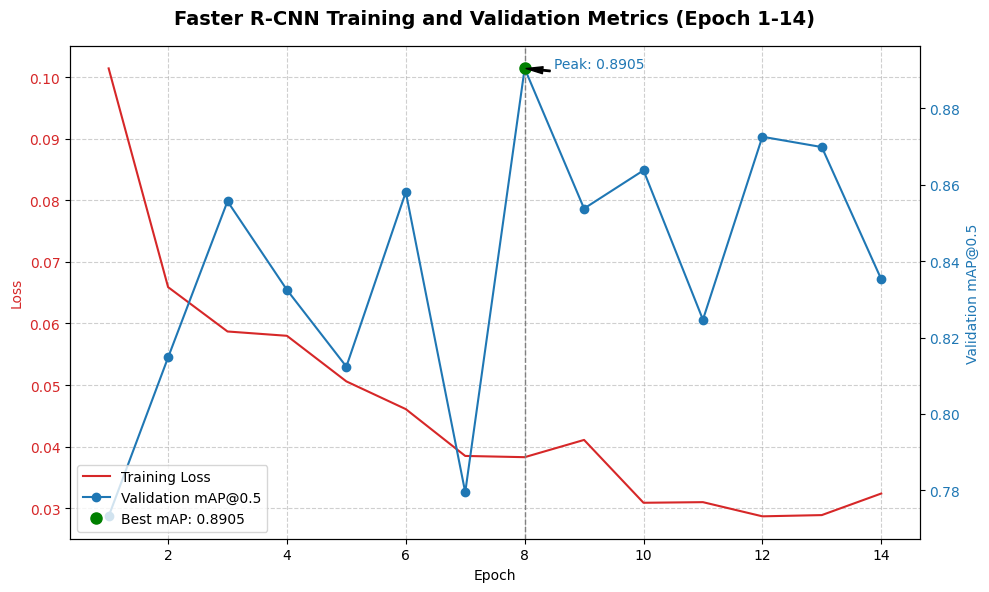


✅ 訓練曲線圖已生成，最佳 mAP 點位於 Epoch 8，數值為 0.8905


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =======================================================
# 數據提取
# =======================================================

# Epoch 數
epochs = list(range(1, 15))

# 訓練損失 (Train Loss)
train_losses = [
    0.1014, 0.0659, 0.0587, 0.0580, 0.0506, 0.0461, 0.0385,
    0.0383, 0.0411, 0.0309, 0.0310, 0.0287, 0.0289, 0.0324
]

# 驗證 mAP@0.5 (Validation mAP@0.5)
val_mAP = [
    0.7732, 0.8148, 0.8557, 0.8325, 0.8124, 0.8581, 0.7795,
    0.8905, 0.8538, 0.8638, 0.8247, 0.8726, 0.8699, 0.8353
]

# 找到最佳 mAP 點
best_mAP = max(val_mAP)
best_epoch = val_mAP.index(best_mAP) + 1

# =======================================================
# 📈 繪製訓練曲線圖 (雙 Y 軸)
# =======================================================

fig, ax1 = plt.subplots(figsize=(10, 6))

# --- 繪製 Loss 曲線 (左 Y 軸) ---
color_loss = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color_loss)
# 這裡我們用 Train Loss 來模擬總體 Loss 趨勢
ax1.plot(epochs, train_losses, color=color_loss, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color_loss)
ax1.grid(True, linestyle='--', alpha=0.6)

# --- 繪製 mAP 曲線 (右 Y 軸) ---
ax2 = ax1.twinx()  # 創建第二個 Y 軸
color_mAP = 'tab:blue'
ax2.set_ylabel('Validation mAP@0.5', color=color_mAP)
ax2.plot(epochs, val_mAP, color=color_mAP, linestyle='-', marker='o', label='Validation mAP@0.5')
ax2.tick_params(axis='y', labelcolor=color_mAP)

# --- 標記最佳 mAP 點 ---
ax2.axvline(x=best_epoch, color='gray', linestyle='--', linewidth=1)
ax2.plot(best_epoch, best_mAP, 'go', markersize=8, label=f'Best mAP: {best_mAP:.4f}') # 綠色圓點標記
ax2.annotate(f'Peak: {best_mAP:.4f}',
             xy=(best_epoch, best_mAP),
             xytext=(best_epoch + 0.5, best_mAP),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
             fontsize=10, color=color_mAP)

# --- 圖表美化 ---
fig.suptitle('Faster R-CNN Training and Validation Metrics (Epoch 1-14)', fontsize=14, weight='bold')
fig.tight_layout() # 調整佈局以防止標籤重疊

# 整合圖例 (需要手動處理雙軸圖例)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left')

plt.show()

print(f"\n✅ 訓練曲線圖已生成，最佳 mAP 點位於 Epoch {best_epoch}，數值為 {best_mAP:.4f}")